In [10]:
import sys

sys.path.append("../berries")


In [20]:
import os
import json
data_dir = "/Data/datasets/arc/"
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Data/datasets/arc/arc-agi_evaluation_challenges.json
/Data/datasets/arc/arc-agi_evaluation_solutions.json
/Data/datasets/arc/arc-agi_test_challenges.json
/Data/datasets/arc/arc-agi_training_challenges.json
/Data/datasets/arc/arc-agi_training_solutions.json
/Data/datasets/arc/sample_submission.json


In [13]:
train_file = "arc-agi_training_challenges.json"
evaluation_file = "arc-agi_evaluation_challenges.json"
test_file = "arc-agi_test_challenges.json"

train_json = json.load(open(data_dir + train_file))


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.backends.backend_pdf import PdfPages

class ARCProcessor:
    cmap = colormaps['tab10']
    norm = plt.Normalize(vmin=0, vmax=9)
    def __init__(self, input_file, output_file):
        self.input_file = input_file
        self.output_file = output_file

    def process(self):
        with open(self.input_file, 'r') as f, PdfPages(self.output_file) as pdf:
            challenges = json.load(f)
            total = len(challenges)
            
            for i, (challenge_id, data) in enumerate(challenges.items(), 1):
                print(f"Processing challenge {i}/{total}: {challenge_id}")
                
                fig = self.plot_one(data, challenge_id)

                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)

        print(f"PDF file '{self.output_file}' has been created.")
    
    @classmethod
    def plot_one(cls, data, challenge_id):
        fig, ax = plt.subplots(figsize=(11, 5))  
        ax.axis('off')
        
        gs = fig.add_gridspec(2, len(data['train']) + 1, hspace=0.1, wspace=0.1)
        axs = gs.subplots()
        
        cls.plot_challenge(data, axs)
        
        fig.suptitle(f"Challenge: {challenge_id}", fontsize=16)
        return fig

    @classmethod
    def plot_challenge(cls, data, axs):
        for t_num, t in enumerate(data['train']):
            cls.plot_grid(axs[0, t_num], t['input'])
            cls.plot_grid(axs[1, t_num], t['output'])
        
        cls.plot_grid(axs[0, -1], data['test'][0]['input'])
        cls.plot_grid(axs[1, -1], np.zeros_like(data['train'][0]['output']))

    @classmethod
    def plot_grid(cls, ax, data):
        ax.imshow(data, cmap=cls.cmap, norm=cls.norm)
        ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
        ax.set_yticks([x - 0.5 for x in range(1 + len(data))])
        ax.set_xticks([x - 0.5 for x in range(1 + len(data[0]))])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

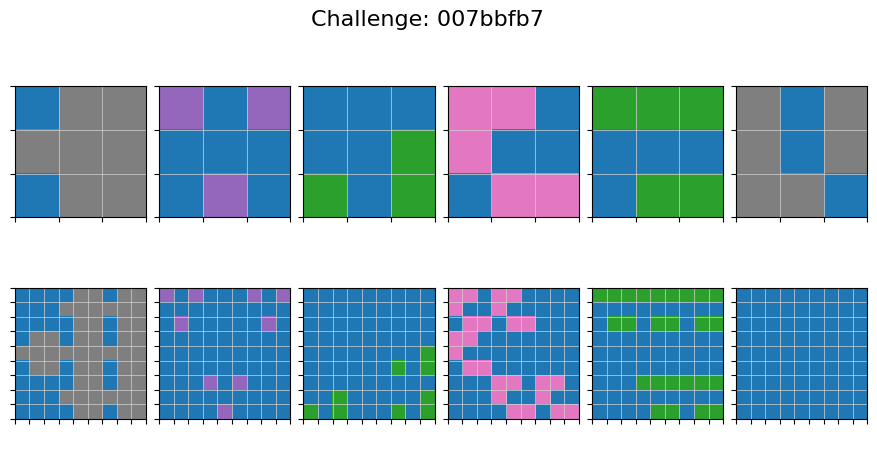

In [33]:
fig = ARCProcessor.plot_one(train_json['007bbfb7'], '007bbfb7')

In [ ]:
d_h_layer = 256
d_h = 256
n_layers = 1
d_in = d_x
# d_out = d_y
d_out = d_x
d_vae_h = 128
beta = 0.2

import nn
import importlib
importlib.reload(nn)
from nn import mglu_net_config, mglu_net, rmglu_net
from pf import F, _

from jax.numpy import mean, exp


def vae_config(d_in, d_h_layer, d_vae_h, d_h, n_layers, init):
    return {
        "encoder":mglu_net_config(d_in, d_h_layer, 2 * d_vae_h, d_h, n_layers, init),
        "decoder": mglu_net_config(d_vae_h, d_h_layer, d_in, d_h, n_layers, init)}

def vae(W, x, noise):
    h = mglu_net(x, W["encoder"])
    mu, log_sigma = h[:d_vae_h], h[d_vae_h:]
    z = mu + noise * log_sigma
    xp = mglu_net(z, W["decoder"])
    return xp, mu, log_sigma



def vae_loss(W, x, noise):
    xp, mu, log_sigma = vae(W, x, noise)
    return ((xp - x) ** 2).mean() - 0.5 * beta * (1 + log_sigma - mu ** 2 - exp(log_sigma)).mean()


loss_b = F(vae_loss).vmap((None, 0, 0), 0)
loss_bm = loss_b >> mean

def vae_test_loss(W, x):
    xp, _, _ = vae(W, x, 0)
    return ((xp - x) ** 2).mean()

test_loss_b = F(vae_test_loss).vmap((None, 0), 0)
test_loss_bm = test_loss_b >> mean

vae_b = F(vae).vmap((None, 0, 0), 0)
